In [1]:
import numpy as np  # For numerical operations
import cv2  # OpenCV for image processing
import os  # For handling file paths
from sklearn.model_selection import train_test_split  # To split the dataset
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score  # Model evaluation
from sklearn.decomposition import PCA  # Dimensionality reduction
from sklearn.preprocessing import LabelEncoder  # Encode emotion labels
from sklearn import svm  # Support Vector Machine
import matplotlib.pyplot as plt  # Visualization

# Function to load and preprocess images from the dataset
def load_images_from_folder(folder_path):
    images = []
    labels = []
    for emotion_label in os.listdir(folder_path):  # Loop through emotion folders
        emotion_folder = os.path.join(folder_path, emotion_label)
        if os.path.isdir(emotion_folder):
            for img_file in os.listdir(emotion_folder):  # Loop through images
                img_path = os.path.join(emotion_folder, img_file)
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Load image in grayscale
                if img is not None:
                    img_resized = cv2.resize(img, (48, 48))  # Resize image to 48x48
                    images.append(img_resized.flatten())  # Flatten to 1D array
                    labels.append(emotion_label)  # Use folder name as label
    return images, labels

# Path to CK+48 dataset (adjust according to your local directory)
dataset_folder = r"D:\Reserach\svm3\CK+48"

# Load the full dataset
X, y = load_images_from_folder(dataset_folder)

# Convert to numpy arrays and normalize pixel values
X = np.array(X) / 255.0
y = np.array(y)

# Split the data into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Encode emotion labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Apply PCA for dimensionality reduction
pca = PCA(n_components=100)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Train SVM model
model = svm.SVC(kernel='linear', C=1.0)
model.fit(X_train_pca, y_train_encoded)

# Predict on the test set
y_pred = model.predict(X_test_pca)

# Evaluate the model
print("Accuracy Score:")
print(f"{accuracy_score(y_test_encoded, y_pred):.2f}")

print("\nClassification Report:")
print(classification_report(y_test_encoded, y_pred, target_names=label_encoder.classes_))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test_encoded, y_pred))

# Visualization of actual vs predicted emotions
# Shuffle indices to ensure randomness
indices = np.arange(len(X_test))
np.random.shuffle(indices)




Accuracy Score:
1.00

Classification Report:
              precision    recall  f1-score   support

       anger       1.00      1.00      1.00        27
    contempt       1.00      1.00      1.00        11
     disgust       1.00      1.00      1.00        35
        fear       1.00      1.00      1.00        15
       happy       1.00      1.00      1.00        42
     sadness       1.00      1.00      1.00        17
    surprise       1.00      1.00      1.00        50

    accuracy                           1.00       197
   macro avg       1.00      1.00      1.00       197
weighted avg       1.00      1.00      1.00       197


Confusion Matrix:
[[27  0  0  0  0  0  0]
 [ 0 11  0  0  0  0  0]
 [ 0  0 35  0  0  0  0]
 [ 0  0  0 15  0  0  0]
 [ 0  0  0  0 42  0  0]
 [ 0  0  0  0  0 17  0]
 [ 0  0  0  0  0  0 50]]


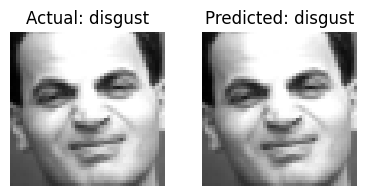

In [2]:
import matplotlib.pyplot as plt  # Visualization

emotions_to_display = ['disgust']
displayed_emotions = {emotion: 0 for emotion in emotions_to_display}  # Track displayed images
num_per_emotion = 1  # Number of images to display per emotion

# Create a list to store the subplots for each emotion
all_images = []

# Iterate over the test set
for i in range(len(X_test)):
    true_label = label_encoder.inverse_transform([y_test_encoded[i]])[0]
    pred_label = label_encoder.inverse_transform([y_pred[i]])[0]

    # Check if we need to display this emotion
    if true_label in emotions_to_display and displayed_emotions[true_label] < num_per_emotion:
        # Store the images and labels for later plotting
        all_images.append((X_test[i], true_label, pred_label))
        displayed_emotions[true_label] += 1

    # Stop once all emotions have been displayed
    if all(count >= num_per_emotion for count in displayed_emotions.values()):
        break

# Create a figure for displaying the images
fig, axes = plt.subplots(
    1, 
    num_per_emotion * 2, 
    figsize=(4, 2)  # Larger figure size for clarity
)

# Ensure `axes` is iterable
if num_per_emotion * 2 == 1:
    axes = [axes]  # Wrap single subplot in a list

# Display the images
for col, (image, true_label, pred_label) in enumerate(all_images):
    # Actual image
    ax_actual = axes[col * 2]
    ax_actual.imshow(image.reshape(48, 48), cmap='gray')
    ax_actual.set_title(f"Actual: {true_label}")
    ax_actual.axis('off')

    # Predicted image
    ax_pred = axes[col * 2 + 1]
    ax_pred.imshow(image.reshape(48, 48), cmap='gray')
    ax_pred.set_title(f"Predicted: {pred_label}")
    ax_pred.axis('off')

plt.tight_layout()
plt.show()